# Drifting Gratings
Organizing data by drifting gratings stimulus

Create manifest to keep track of data

In [1]:
from allensdk.core.brain_observatory_cache import BrainObservatoryCache
import pprint

# This class uses a 'manifest' to keep track of downloaded data and metadata.  
# All downloaded files will be stored relative to the directory holding the manifest
# file.  If 'manifest_file' is a relative path (as it is below), it will be 
# saved relative to your working directory.  It can also be an absolute path.
boc = BrainObservatoryCache()

Import stim info data

In [2]:
import allensdk.brain_observatory.stimulus_info as stim_info


Import required packages for code

In [3]:
from matplotlib import pyplot as plt
#%matplotlib inline
import matplotlib.pyplot as plt
import matplotlib.patches as patches

import numpy as np
import cmath

import pandas as pd

def plot_stimulus_table(stim_table, title):
    fstart = stim_table.start.min()
    fend = stim_table.end.max()
    
    fig = plt.figure(figsize=(15,1))
    ax = fig.gca()
    for i, trial in stim_table.iterrows():    
        x1 = float(trial.start - fstart) / (fend - fstart)
        x2 = float(trial.end - fstart) / (fend - fstart)            
        ax.add_patch(patches.Rectangle((x1, 0.0), x2 - x1, 1.0, color='r'))
    ax.set_xticks((0,1))
    ax.set_xticklabels((fstart, fend))
    ax.set_yticks(())
    ax.set_title(title)
    ax.set_xlabel("frames")


In [4]:
# Download cells for a set of experiments and convert to DataFrame
cells = boc.get_cell_specimens() # this code may be moved outside of the function?
cells = pd.DataFrame.from_records(cells)
print("total cells: %d" % len(cells))

total cells: 63251


 FUNCTIONS

In [5]:
# plot_dg(freq, ori, dsi_cell, data_set, print_graphs, plot_stim_instances, plot_avg_graph, plot_trial_on_avg, 
# freq_ind, ori_ind, axs): calculates average dff for a single type of stim. 
#
#
#
#
# freq: temporal frequency of stimulus
# ori: orientation of stimulus
# dsi_cell: NWB file for cell
# data_set:  ophys experiment data
# print_graphs: boolean value, if true, plots all of the 15 trials for each stim
# plot_stim_instances: boolean value, if true, shows a plot of the frames each stim is shown
# plot_avg_graph: boolean value, if true, shows average plot of each stim
# plot_trial_on_avg: boolean value, if true, shows trial plots on same plot as avg
# ori_ind: indice of orientation axis for subplots
# freq_ind: indice of frequency axis for subplots
# axs: subplot object
def plot_dg(freq, ori, dsi_cell, data_set, print_graphs, plot_stim_instances, plot_avg_graph, plot_trial_on_avg, 
            freq_ind, ori_ind, axs):
    
    # get flourescence traces for target cell
    dsi_cell_id = dsi_cell['cell_specimen_id']
    time, f_traces = data_set.get_corrected_fluorescence_traces(cell_specimen_ids=[dsi_cell_id])
    
    # this is a pandas DataFrame. find trials with a given stimulus condition.
    # 40 diff total conditions
    temporal_frequency = freq
    orientation = ori
    stim_table = data_set.get_stimulus_table('drifting_gratings')
    stim_table = stim_table[(stim_table.temporal_frequency == temporal_frequency) & 
                            (stim_table.orientation == orientation)]
    
    # plot of instances of stimulus frames
    if (plot_stim_instances) :
        plot_stimulus_table(stim_table, "Instances of Stimuli, TF %d ORI %d" % (temporal_frequency, orientation))
        plt.show()
    
    # make 2D array of 120 data points of f_traces and dff_traces for each of the 15 trials
    all_f_traces = [[0]*120 for i in range(15)] 
    dff_traces = [[0]*120 for i in range(15)] 
    x=0
    
    # plot 15 trial graphs
    # initialize trial graph subplots
    if (print_graphs):
        fig_trial, axs_trial = plt.subplots(3, 5, sharey=True, figsize=(10,10))
        fig_trial.suptitle("15 Trials for Stimuli, TF %d ORI %d" % (temporal_frequency, orientation))
    x_ind = 0 
    y_ind = 0
    
    for start_ind in stim_table.start:
        
        all_f_traces[x] = f_traces[0][start_ind-30:start_ind+90] # get f_traces at desired indices
        F0 = np.mean(f_traces[0][start_ind-30:start_ind]) # calculate baseline as the preceding second before stim
        dff_traces[x] = (all_f_traces[x]-F0)/F0  # calculate dff at desired indices
        
        if (plot_avg_graph and plot_trial_on_avg) :
            axs[freq_ind, ori_ind].plot(time[0:120]-time[0]-1, dff_traces[x], color='tan')
        if (print_graphs) :
            axs_trial[x_ind, y_ind].plot(time[0:120]-time[0]-1, dff_traces[x], color='tan')
            axs_trial[x_ind, y_ind].set_title("Frames %d to %d" % (start_ind-30,start_ind+90),
                                              fontdict = {'fontsize': 7})

            # Mark the area of the stimulus
            axs_trial[x_ind, y_ind].fill_between(time[0:60]-time[0], min(dff_traces[x]), 
                                                                         min(dff_traces[x])+0.005,
                facecolor="orange", # The fill color
                color='blue',       # The outline color
                alpha=0.4)          # Transparency of the fill
            
            for ax in axs_trial.flat:
                ax.set(xlabel='sec', ylabel='dF/F')
            for ax in axs_trial.flat:
                ax.label_outer()

            y_ind +=1 
            if (y_ind > 4) : 
                y_ind = 0
                x_ind +=1
        
        x+=1
    
    # calculate and plot the average response of all graphs
    mean_dff = np.mean(dff_traces, axis=0)
    
    if (plot_avg_graph) :
        axs[freq_ind,ori_ind].plot(time[0:120]-time[0]-1,mean_dff, color='black')
        axs[freq_ind,ori_ind].set_title("TF %d ORI %d" %(temporal_frequency, orientation))
        axs[freq_ind,ori_ind].fill_between(time[0:60]-time[0], 
                min(mean_dff), min(mean_dff)+0.005,
                facecolor="orange", # The fill color
                color='blue',       # The outline color
                alpha=0.4)          # Transparency of the fill
    
    # calculate single value average dff from average graph
    return np.mean(mean_dff[30:90])
    
    

In [6]:
# dg_for_cell(index, plot_trial_graphs, plot_stim_instances, plot_avg_graph, plot_trial_on_avg, show_text) : given
# a cell index, will calculate and return Rmax, pref TF, pref ORI, Rorth, OSI and gOSI values. Will print 
# metadata, avg response graphs for each kind of stim, and trial graphs if desired. 
# 
#
#
# boc : manifest that keeps track of downloaded data
# dsi_cells: object containing all direction selective cells in given brain region
# index: index of cell in vector of filtered direction selective cells. There are 1159 direction selective cells. 
# Index values can range from 0 to 1158
# plot_trial_graphs: boolean value, if true, shows all of the 15 trials for each stim
# plot_stim_instances: boolean value, if true, shows a plot of the frames each stim is shown
# plot_avg_graph: boolean value, if true, shows average plot of each stim
# plot_trial_on_avg: boolean value, if true, shows trial plots on same plot as avg
# show_text: boolean value, if true, prints text information such as cell metadata, stimulus matrix,
# and outputs of analysis calculations
# cre_lines_list: if not empty, will filter cells by the given cell types 
#
# Warning- calling this function will require downloading the ophys experiment data, which may take some time
# This function downloads the NWB files that contain the fluorescence traces for segmented cells in 
# those experiments that used the dg stim
def dg_for_cell(boc, dsi_cells, index, plot_trial_graphs, plot_stim_instances, plot_avg_graph, plot_trial_on_avg, 
                show_text, cre_lines_list): 
    
    # pick a direction-selective cell and find its NWB file
    dsi_cell = dsi_cells.iloc[index]
    
    # determine and filter by cell type
    cell_type = dsi_cell.tld1_name
    for cre_line in cre_lines_list:
        if (cell_type == cre_line):
            continue
        if (cre_line == cre_lines_list[-1]) : 
            return None
    
    # figure out which ophys experiment has the drifting gratings stimulus for that cell
    cell_exp = boc.get_ophys_experiments(cell_specimen_ids=[dsi_cell['cell_specimen_id']],
                                         stimuli=[stim_info.DRIFTING_GRATINGS])[0]

    data_set = boc.get_ophys_experiment_data(cell_exp['id'])
    
    if (show_text):
        print("Metadata from NWB file:")
        pprint.pprint(data_set.get_metadata())
    
    # initialize stim_matrix
    stim_matrix = [[0]*8 for i in range(5)]
    
    # initialize avg graph subplots
    if (plot_avg_graph) :
        fig, axs = plt.subplots(5, 8, sharey=True, figsize=(15,15))
        fig.suptitle('Average Fluorescence For Each Stim')
        for ax in axs.flat:
            ax.set(xlabel='sec', ylabel='dF/F')
        for ax in axs.flat:
            ax.label_outer()
    else :
        axs = None 
        
    # make avg graph subplots and calculate average dff for each stim
    freq_array = [1,2,4,8,15]
    ori_array = [0,45,90,135,180,225,270,315]
    freq_ind = 0
    for freq in freq_array :
        ori_ind = 0
        for ori in ori_array :
            avg_dff = plot_dg(freq, ori, dsi_cell, data_set, plot_trial_graphs, plot_stim_instances, 
                              plot_avg_graph, plot_trial_on_avg, freq_ind, ori_ind, axs)
            stim_matrix[freq_ind][ori_ind] = avg_dff
            ori_ind +=1
        freq_ind += 1
    
    # print stim_matrix
    row_labels = ['1', '2', '4', '8', '15']
    column_labels = ['0','45','90','135','180','225','270','315']
    if (show_text):
        print(pd.DataFrame(stim_matrix, columns=column_labels, index=row_labels))
    
    # calc R max val in stim_matrix
    Rmax = np.amax(stim_matrix)
    if (show_text): print("Cell has Rmax of %f" % Rmax)
    result = np.where(stim_matrix == np.amax(stim_matrix))
    max_coor = list(zip(result[0], result[1]))
    if (show_text): print("At temporal frequency of %d and orientation of %d" % 
          (freq_array[max_coor[0][0]], ori_array[max_coor[0][1]]))
    
    # calc R orth
    Rorth = (stim_matrix[max_coor[0][0]][max_coor[0][1]-2] + stim_matrix[max_coor[0][0]][(max_coor[0][1]+2)%8])/2
    if (show_text): print("Rorth: %f" % Rorth)
    
    # calc OSI
    OSI = (Rmax - Rorth)/(Rmax + Rorth)
    if (show_text): print("OSI: %f" % OSI)
    
    # calc gOSI
    Rtheta=0
    Rtheta_exp=0
    for i in range(0, 8) :
        Rtheta += stim_matrix[max_coor[0][0]][i]
        Rtheta_exp += (Rtheta * cmath.exp(complex(0,2)*ori_array[i]))
    gOSI = abs(Rtheta_exp/Rtheta)
    if (show_text): print("gOSI: %f" % gOSI)
    
    # find cre_line
    cre_line = cell_exp['cre_line']
    
    # return array of Rmax, pref TF, pref ORI, Rorth, OSI, gOSI values, and cre_line
    return [Rmax, freq_array[max_coor[0][0]], ori_array[max_coor[0][1]], Rorth, OSI, gOSI, cre_line]
    

In [21]:
# create_histogram(targeted_struct): creates histogram of OSI of all cells in desired cortical layer
# 
#
#
#
# targeted_struct: string argument identifying desired cortical layer. Options are
# 'VISal', 'VISam', 'VISl', 'VISp', 'VISpm', 'VISrl'. Higher order visual cortices (VISam, VISpm, VISrl) show
# decreased activity with increased running speed
# print_OSIs: when set to true, will print the OSIs for each cell
# print_other_vals: when set to true, will print the Rmax, pref TF, pref ORI, Rorth, and gOSI
# filter_vals: when set to true, creates the histogram and excludes OSIs below 0 or above 2
# cre_lines_list: given one or multiple cre_lines, will filter the cells of the targeted structure to those cells
# max_cells: if given a value, will only run a maximum of that amount of cells
#
# Warning: will require downloading nwb files for many cells. Will take a while 
def create_histogram(targeted_struct, print_OSIs, print_other_vals, filter_vals, cre_lines_list, max_cells):
    
    # Download experiment containers for experiments of target structure
    exp_containers = boc.get_experiment_containers(targeted_structures=[targeted_struct])
    print("all %s experiment containers: %d" % (targeted_struct, len(exp_containers)))
    
    # Download cells for a set of experiments and convert to DataFrame
    #cells = boc.get_cell_specimens() # this code may be moved outside of the function?
    #cells = pd.DataFrame.from_records(cells)
    #print("total cells: %d" % len(cells))

    # find direction selective cells in target_struct
    exp_container_ids = [ ec['id'] for ec in exp_containers ]
    structure_cells = cells[cells['experiment_container_id'].isin(exp_container_ids)]
    print("%s cells: %d" % (targeted_struct, len(structure_cells)))

    # significant response to drifting gratings stimulus
    sig_cells = structure_cells[structure_cells['p_dg'] < 0.05]
    print("cells with sig. response to drifting gratings: %d" % len(sig_cells))
    
    dsi_cells = sig_cells

    # direction selective cells
    #dsi_cells = sig_cells[(sig_cells['g_dsi_dg'] > 0.75)]  #lower threshold or get rid of entirely?
    #print("direction-selective cells: %d" % len(dsi_cells))

    OSIs = []
    OSI_index=0
    index = 0
    
    if (max_cells != None) : # decide max cells desired in histogram 
        max_runs = max_cells
    else : 
        max_runs = len(dsi_cells)

    while (OSI_index < max_runs) and (index < len(dsi_cells)):
        cell_vals = dg_for_cell(boc, dsi_cells, index, False, False, False, False, False, cre_lines_list)
        if (cell_vals != None) :
            OSI = cell_vals[4] 
            if(filter_vals) :
                if(0 <= OSI <= 2):
                    OSIs.append(OSI)
                    if (print_OSIs) : print(OSI_index, "Cell", index, "OSI:", OSI)
                    if (print_other_vals) : 
                        print("Rmax:", cell_vals[0])
                        print("Pref TF:", cell_vals[1])
                        print("Pref ORI:", cell_vals[2])
                        print("Rorth:", cell_vals[3])
                        print("gOSI:", cell_vals[5])
                    OSI_index += 1
            else : 
                OSIs.append(OSI)
                if (print_OSIs) : print(OSI_index, "Cell", index, "OSI:", OSI)
                if (print_other_vals) : 
                    print("Rmax:", cell_vals[0])
                    print("Pref TF:", cell_vals[1])
                    print("Pref ORI:", cell_vals[2])
                    print("Rorth:", cell_vals[3])
                    print("gOSI:", cell_vals[5])
                OSI_index += 1
        index += 1
    
    if not OSIs : # if OSIs is empty
        print("0 OSI values collected")
        
    plt.hist(list(OSIs), 50, density = 1)
    if (filter_vals): plt.title("Distribution of OSI values for %s cells in %s (after filtering)" % 
                               (cre_lines_list, targeted_struct))
    else : plt.title("Distribution of OSI values for %s cells in %s (prior to filtering)" % 
                     (cre_lines_list, targeted_struct))
    plt.xlabel('Orientation Selectivity Index for Drifting Gratings')
    plt.ylabel('Number of Cells')
    

TESTS

In [15]:
# This function downloads the NWB files that contain the fluorescence traces for segmented cells in 
# those experiments that used the dg stim
 # Download experiment containers for experiments of target structure
targeted_struct = 'VISp'
exp_containers = boc.get_experiment_containers(targeted_structures=[targeted_struct])
print("all %s experiment containers: %d" % (targeted_struct, len(exp_containers)))

# Download cells for a set of experiments and convert to DataFrame
cells = boc.get_cell_specimens() # this code may be moved outside of the function?
cells = pd.DataFrame.from_records(cells)
print("total cells: %d" % len(cells))

# find direction selective cells in VISp
exp_container_ids = [ ec['id'] for ec in exp_containers ]
structure_cells = cells[cells['experiment_container_id'].isin(exp_container_ids)]
print("%s cells: %d" % (targeted_struct, len(structure_cells)))

# significant response to drifting gratings stimulus
sig_cells = structure_cells[structure_cells['p_dg'] < 0.05]
print("cells with sig. response to drifting gratings: %d" % len(sig_cells))

# direction selective cells
dsi_cells = sig_cells[(sig_cells['g_dsi_dg'] > 0.9)]
print("direction-selective cells: %d" % len(dsi_cells))

cellInfo = dg_for_cell(boc, dsi_cells, 30, False, False, False, True, True)
print(cellInfo[6])

all VISp experiment containers: 216


KeyboardInterrupt: 

In [12]:
# see all options for cre_lines
cre_lines = boc.get_all_cre_lines()
print("all cre lines:\n")
pprint.pprint(cre_lines)

all cre lines:

['Cux2-CreERT2',
 'Emx1-IRES-Cre',
 'Fezf2-CreER',
 'Nr5a1-Cre',
 'Ntsr1-Cre_GN220',
 'Pvalb-IRES-Cre',
 'Rbp4-Cre_KL100',
 'Rorb-IRES2-Cre',
 'Scnn1a-Tg3-Cre',
 'Slc17a7-IRES2-Cre',
 'Sst-IRES-Cre',
 'Tlx3-Cre_PL56',
 'Vip-IRES-Cre']


all VISp experiment containers: 216
VISp cells: 22641
cells with sig. response to drifting gratings: 13401


2022-08-07 16:32:24,446 allensdk.api.api.retrieve_file_over_http INFO     Downloading URL: http://api.brain-map.org/api/v2/well_known_file_download/617968149


0 Cell 6705 OSI: 0.8146119548515731
1 Cell 6706 OSI: 0.9421720669009046
2 Cell 6707 OSI: 0.7228118650897847
3 Cell 6708 OSI: 0.9937465952978202
4 Cell 6709 OSI: 1.1055833109669126
5 Cell 6710 OSI: 0.6838726770779849
6 Cell 6711 OSI: 1.0158271188661403
7 Cell 6712 OSI: 0.798370092527988
8 Cell 6713 OSI: 1.9610280703360448
9 Cell 6714 OSI: 1.0763823638608248
10 Cell 6716 OSI: 0.6854456419635473
11 Cell 6717 OSI: 0.8985741652207073
12 Cell 6718 OSI: 1.4068116815190477
13 Cell 6719 OSI: 1.0129777863553342
14 Cell 6720 OSI: 1.2295956861730877
15 Cell 6721 OSI: 0.6210212100783185
16 Cell 6722 OSI: 0.6226607865291883
17 Cell 6723 OSI: 0.9719080779430177
18 Cell 6724 OSI: 1.2694496920394298
19 Cell 6725 OSI: 0.9898234472206364
20 Cell 6726 OSI: 0.6560772939923815
21 Cell 6727 OSI: 0.9946160160963003
22 Cell 6728 OSI: 0.6339585415270166
23 Cell 6729 OSI: 1.0879193357413346
24 Cell 6730 OSI: 0.5587469078367511
25 Cell 6731 OSI: 0.7914444668544743
26 Cell 6732 OSI: 0.3300553093143481
27 Cell 6733

2022-08-07 16:45:18,955 allensdk.api.api.retrieve_file_over_http INFO     Downloading URL: http://api.brain-map.org/api/v2/well_known_file_download/637889791


86 Cell 6797 OSI: 0.5443926880021243
87 Cell 6798 OSI: 1.4127176373795993
88 Cell 6799 OSI: 1.3920746662335948
89 Cell 6800 OSI: 1.7081410324908457
90 Cell 6801 OSI: 0.903550473924214
91 Cell 6802 OSI: 0.8193805685397479
92 Cell 6803 OSI: 1.1049432290037464
93 Cell 6804 OSI: 1.3945737796222126
94 Cell 6805 OSI: 1.1243873344509299
95 Cell 6806 OSI: 0.5939480781024025
96 Cell 6807 OSI: 1.5980519021511606
97 Cell 6808 OSI: 0.8250766929753965
98 Cell 6809 OSI: 1.7982766641733094
99 Cell 6810 OSI: 0.7720077738331783


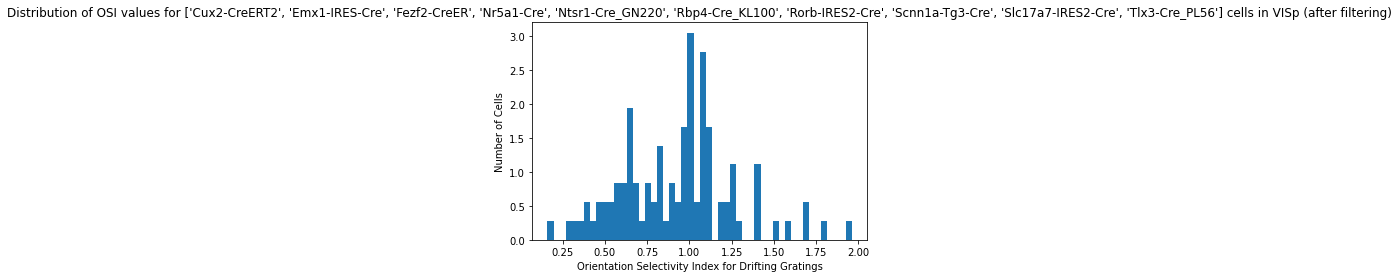

In [31]:
create_histogram('VISp', True, False, True, ['Cux2-CreERT2','Emx1-IRES-Cre','Fezf2-CreER','Nr5a1-Cre','Ntsr1-Cre_GN220',
                                            'Rbp4-Cre_KL100','Rorb-IRES2-Cre','Scnn1a-Tg3-Cre','Slc17a7-IRES2-Cre',
                                            'Tlx3-Cre_PL56'], 100)




all VISl experiment containers: 118
VISl cells: 13618
cells with sig. response to drifting gratings: 6985
0 Cell 2682 OSI: 1.781973129170481
1 Cell 2684 OSI: 1.5203479682149952
2 Cell 2686 OSI: 0.7055622482432613
3 Cell 2687 OSI: 0.6794772803865285
4 Cell 3256 OSI: 1.180796020460204
5 Cell 3257 OSI: 0.9818422514059253
6 Cell 3271 OSI: 1.8303880836657442
7 Cell 3272 OSI: 0.45383741381218473
8 Cell 3273 OSI: 1.0886865067268618
9 Cell 3274 OSI: 1.2150721552227304
10 Cell 3305 OSI: 0.48648231195312724
11 Cell 3307 OSI: 1.5002044029375083
12 Cell 3309 OSI: 1.168935300908543
13 Cell 3310 OSI: 1.1958412293997334
14 Cell 3311 OSI: 1.2782499621364685
15 Cell 3317 OSI: 1.830545154187566
16 Cell 3318 OSI: 0.56683143205609
17 Cell 3319 OSI: 0.9549465936124784
18 Cell 3320 OSI: 1.0802579973152646
19 Cell 3323 OSI: 1.3759238576102513
20 Cell 3325 OSI: 1.9143357864357144
21 Cell 3327 OSI: 1.8590787847588468
22 Cell 3328 OSI: 1.1550524015936494
23 Cell 3330 OSI: 0.7723759890602258
24 Cell 3336 OSI: 0.

2022-08-07 15:51:12,422 allensdk.api.api.retrieve_file_over_http INFO     Downloading URL: http://api.brain-map.org/api/v2/well_known_file_download/657239178


90 Cell 5534 OSI: 0.909936063284916
91 Cell 5536 OSI: 0.8355012683361426
92 Cell 5537 OSI: 0.9753670676265626
93 Cell 5538 OSI: 1.5588502901865962
94 Cell 5539 OSI: 1.0733858024640155
95 Cell 5540 OSI: 1.0222987437845663
96 Cell 5542 OSI: 1.8160410074644706
97 Cell 5543 OSI: 0.5993520403251855
98 Cell 5545 OSI: 0.4331215405443653
99 Cell 5546 OSI: 1.1045875574594566


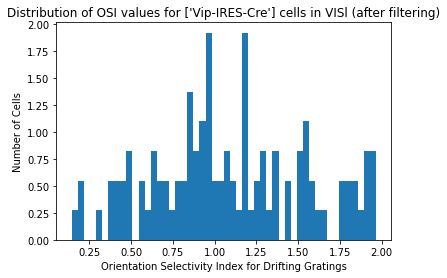

In [28]:
create_histogram('VISl', True, False, True, ['Vip-IRES-Cre'], 100)



Run to see data analysis done by the Allen Institute (peak response, OSI, gOSI, etc.) 

In [17]:
dsi_cell = dsi_cells.iloc[15]
print("Peak dff: Allen %0.3f" % dsi_cell.peak_dff_dg, "vs. est %0.3f" % (cellInfo[0]*100))
print("Pref dir: Allen %0.f" % dsi_cell.pref_dir_dg, "vs. est %0.f" % cellInfo[2])
print("Pref tf: Allen %0.f" % dsi_cell.pref_tf_dg, "vs. est %0.f" % cellInfo[1])
print("OSI: Allen %.2f" % dsi_cell.osi_dg, "vs. est %.2f" % cellInfo[4])

Peak dff: Allen 1.533 vs. est 1.533
Pref dir: Allen 0 vs. est 0
Pref tf: Allen 1 vs. est 1
OSI: Allen 1.28 vs. est 1.28
